In [1]:
%pylab inline
import convis

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: Quadro K620 (CNMeM is disabled, cuDNN not available)


(500, 10, 10) (500, 10, 10) (500, 10, 10)


{}

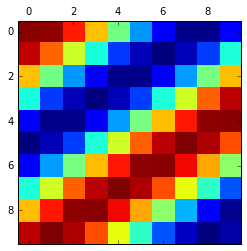

In [2]:
the_input = np.zeros((500,10,10))
T,X,Y = np.meshgrid(np.linspace(0.0,10.0,the_input.shape[0]),np.linspace(-1.0,1.0,the_input.shape[1]),np.linspace(-1.0,1.0,the_input.shape[2]), indexing='ij')
print T.shape,X.shape,Y.shape
the_input += np.sin(T+3.0*X+2.0*Y) #+ np.sin(T+9.0*X+6.0*Y) 
matshow(the_input[5])
convis.describe(the_input)

In [3]:
conf1 = convis.retina.RetinaConfiguration()
ground_truth = 4.0*rand()-2.0
print ground_truth
conf1.set('outer-plexiform-layers.*.linear-version.opl-relative-weight',ground_truth)
m = convis.retina.Retina(conf1,ganglion_spikes=False)
m.create_function()
def compute_goal(the_input):
    o = m.run(the_input)
    return o[0]
o_goal = compute_goal(the_input)
figure()
convis.describe(o_goal)

{}

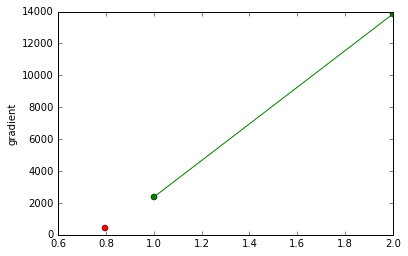

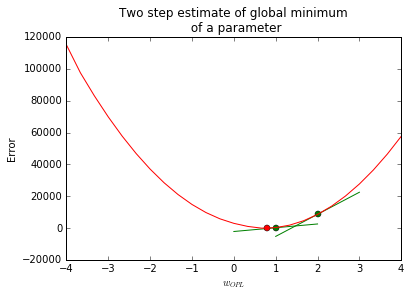

In [24]:
import theano
import theano.tensor as T

conf2 = convis.retina.RetinaConfiguration()
conf2.set('outer-plexiform-layers.*.linear-version.opl-relative-weight',1.0)
m2 = convis.retina.Retina(conf2,ganglion_spikes=False)

the_var = m2.variables.OPL.w_OPL

goal_input = convis.as_input(T.dtensor3(),name='goal')
error_term = (m2.outputs[0]-goal_input)**2
grad_term = theano.grad(T.mean(error_term),the_var)
m2.outputs.append(error_term)
m2.outputs.append(grad_term)
m2.create_function(updates = {the_var: the_var - 0.1*grad_term}, 
                   additional_inputs=[goal_input])

def do_run():
    global the_input
    global o_goal
    o_goal = compute_goal(the_input)
    global noise_level
    o_fit = m2.run(the_input,additional_inputs=[o_goal+noise_level*rand(*o_goal.shape)])
    return o_fit

x1 = 1.0
colors = cm.gnuplot2(np.linspace(0.1,0.9,50))
error = []
kernel_mean = []
estimated_kernels = []
epsilon = 0.01
noise_level = 0.001
step = 1.0

the_var.set_value(x1)
o_fit = do_run()
# first sample of gradient
e1 = o_fit[error_term]
g1 = o_fit[grad_term]

x2 = x1 + np.sign(np.mean(g1))* step
the_var.set_value(x2)
o_fit = do_run()
# second sample of gradient
e2 = o_fit[error_term]
g2 = o_fit[grad_term]

"""
We estimated two points on the linear trajectory:

(0,g1) at the initial (homogeneous) kernel (`new_kernel`)

(-step,g2) at the initial kernel minus step * the first gradient

The magnitudes of the two gradients form a line that intersects 
the x-axis where the minimum of the error function will be.
"""

incline = (np.mean(g1)-np.mean(g2))/(x1-x2)
minimum = -np.mean(g1)/incline
optimal_value = x1 + minimum
x3 = optimal_value

the_var.set_value(x3)
o_fit = do_run()
e3 = o_fit[error_term]
g3 = o_fit[grad_term]



figure()
plot([x1,x2],[np.mean(g1),np.mean(g2)],'go-')
plot(x3,np.mean(g3),'ro')
ylabel('gradient')

figure()
plot(x1,np.mean(e1),'go')
plot([x1+1.0,x1-1.0],[np.mean(e1)+np.mean(g1),np.mean(e1)-np.mean(g1)],'g-')
plot(x2,np.mean(e2),'go')
plot([x2+1.0,x2-1.0],[np.mean(e2)+np.mean(g2),np.mean(e2)-np.mean(g2)],'g-')
plot(x3,np.mean(e3),'ro')
ylabel('Error')


e4 = []
vs = np.linspace(-4.0,4.0,25)
for r in vs:
    the_var.set_value(r)
    o_fit = do_run()
    e4.append(np.mean(o_fit[error_term]))
plot(vs,e4,'r-')
title('Two step estimate of global minimum\n of a parameter')
xlabel('$w_{OPL}$')

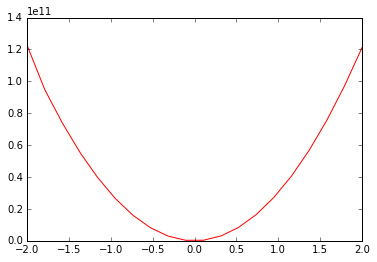

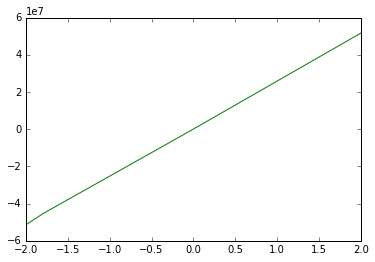

In [9]:
e5 = []
g5 = []
vs = np.linspace(-2.0,2.0,20)
for r in vs:
    the_var.set_value(new_kernel + r*g1)
    o_fit = do_run()
    e5.append(np.mean(o_fit[error_term]))
    g5.append(np.mean(o_fit[grad_term]))
plot(vs,e5,'r-')
figure()
plot(vs,g5,'g-')

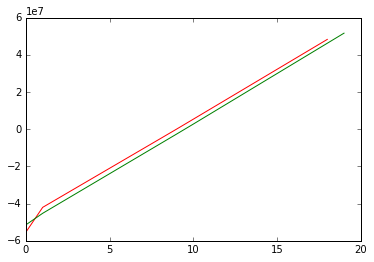

In [21]:
plot(np.diff(e5)/500.0,'r-')
plot(g5,'g-')